In [1]:
'''
Shepard, Roger N., Carl I. Hovland, and Herbert M. Jenkins. (1961).
Learning & Memorization of Classifications. Psychological Monographs:
General and Applied 75(13).
'''
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import itertools as it
import sys
from tqdm import tqdm
sys.path.append('..')
import sea

In [2]:
# %% Parameters
param = {
    # how many steps one looksahead? 0 is myopic (1 step ahead) and so on..
    'MAX_RECURSION_LEVEL':  5,
    'EXPLORATION_PARAM':    0.0,
    'DECISION_PARAMETER':   1.0,
    'TOTAL_BLOCKS':         28,
    'CONSEC_BLOCKS':        2,
    'prior_matrix':         np.array([
                                [.01, .01],
                                [1.0, 1.0],
                                [1.0, 1.0],
                                [1.0, 1.0], ]),
    'num_dims':              4,
    'num_values':            2,
    'coupling':             .3,
    'd':                     1.0,
    'report':                False,
    'NUM_TIMES':             5  # nreps of the six problems
}

# uses a binary feature (one unit) for the first three dims and two
# features for the output to facillitate choice.
SHEP_STIM = np.array((
                # type 1
                [[0, 0, 0, 0],  
                 [0, 0, 0, 1],
                 [0, 0, 1, 0],
                 [0, 0, 1, 1],
                 [1, 1, 0, 0],
                 [1, 1, 0, 1],
                 [1, 1, 1, 0],
                 [1, 1, 1, 1]],
                 
                 # type 2
                [[0, 0, 0, 0],  
                 [0, 0, 0, 1],
                 [1, 0, 1, 0],
                 [1, 0, 1, 1],
                 [1, 1, 0, 0],
                 [1, 1, 0, 1],
                 [0, 1, 1, 0],
                 [0, 1, 1, 1]],
                 
                 # type 3
                [[0, 0, 0, 0],  
                 [0, 0, 0, 1],
                 [0, 0, 1, 0],
                 [1, 0, 1, 1],  # *
                 [1, 1, 0, 0],
                 [0, 1, 0, 1],  # *
                 [1, 1, 1, 0],
                 [1, 1, 1, 1]],
                 
                 # type 4
                [[0, 0, 0, 0],  
                 [0, 0, 0, 1],
                 [0, 0, 1, 0],
                 [1, 0, 1, 1],  # *
                 [0, 1, 0, 0],  # *
                 [1, 1, 0, 1],
                 [1, 1, 1, 0],
                 [1, 1, 1, 1]],
                 
                 # type 5
                [[0, 0, 0, 0],  
                 [0, 0, 0, 1],
                 [0, 0, 1, 0],
                 [1, 0, 1, 1],  # *
                 [1, 1, 0, 0],
                 [1, 1, 0, 1],
                 [1, 1, 1, 0],
                 [0, 1, 1, 1]],  # *
                 
                 # type 6
                [[0, 0, 0, 0],  
                 [1, 0, 0, 1],
                 [1, 0, 1, 0],
                 [0, 0, 1, 1],
                 [1, 1, 0, 0],
                 [0, 1, 0, 1],
                 [0, 1, 1, 0],
                 [1, 1, 1, 1]]))


SHEP_KNOWN = np.array([
                [0, 1, 1, 1],  # features known when stimulus is presented.
                [0, 1, 1, 1],
                [0, 1, 1, 1],
                [0, 1, 1, 1],
                [0, 1, 1, 1],
                [0, 1, 1, 1],
                [0, 1, 1, 1],
                [0, 1, 1, 1]])

ALL_KNOWN = np.array([1, 1, 1, 1])


SHEP_QUERY = np.array([
                [1, 0, 0, 0],  # features queried
                [1, 0, 0, 0],
                [1, 0, 0, 0],
                [1, 0, 0, 0],
                [1, 0, 0, 0],
                [1, 0, 0, 0],
                [1, 0, 0, 0],
                [1, 0, 0, 0]])


# human data from table 1 in Nosofsky 1994:
SHEP_HUMAN = pd.read_csv(
    'behavioral_results/nosofsky1994LearningCurves.csv',
    index_col=0).T.values

In [3]:
# % functions for computing utility:


def getSituationCost(KNOWN_VEC, param):
    '''function to calculate costs for a given KNOWN_VEC (see RMC.SituationValue)

    This function assumes equal costs for each query. Can be modified for
    tasks in which some tests are more costly than others, or when sampling costs
    are not independent.'''

    return np.sum(KNOWN_VEC) * 10  # 10 is sampling cost used in paper


def dfActionVals(param):
    '''function to define utility table (e.g., table 1)
    returns dataframe
    '''

    m = np.diag([100] * param['num_values'])
    df = pd.DataFrame(index=['s%d' % a for a in range(param['num_values'])],
                      columns=['a%d' % a for a in range(param['num_values'])],
                      data=m)
    return df


param['getSituationCost'] = getSituationCost
param['dfActionVals'] = dfActionVals(param)


In [4]:
# %% Standard Model

model = sea.RMC(param)

blocks_correct_consec = 0
overall_correct = np.zeros([6, param['TOTAL_BLOCKS']])
overall_sampled = np.zeros([6, param['TOTAL_BLOCKS']])
item_order = np.arange(8)
lastFourBlocksSampled = np.zeros([6])
blocksToCriterion = np.zeros([6])


nDimSampledByStim = np.zeros((param['TOTAL_BLOCKS'], 6, len(item_order)))
nCorrectProbByStim = np.ones(
    (param['NUM_TIMES'], param['TOTAL_BLOCKS'], 6, len(item_order)))
mndim = np.zeros((param['NUM_TIMES'], 6, param['TOTAL_BLOCKS']))
dMod = {}
for problem_num in range(6):
    dMod[problem_num] = {}
    for run_num in tqdm(range(param['NUM_TIMES']),desc='problem %d'%(problem_num+1)):
        model.Reset()
        criterion = False
        sim_correct = np.zeros(param['TOTAL_BLOCKS'])
        numberDimSampled = np.zeros(param['TOTAL_BLOCKS'])
        for num_block in range(param['TOTAL_BLOCKS']):
            np.random.shuffle(item_order)
            blockCorrectProb = 1.0

            for item_num in item_order:

                ITEM_VEC = SHEP_STIM[problem_num][item_num]
                KNOWN_VEC = SHEP_KNOWN[item_num]
                tempN = model.PresentStimulus(ITEM_VEC, KNOWN_VEC)

                nDimSampledByStim[num_block,
                                  problem_num, item_num] += len(tempN)
                SAMPLED_KNOWN = np.zeros(model.NUM_DIMS)
                SAMPLED_KNOWN[tempN] = 1

                numberDimSampled[num_block] += len(tempN)

                correctProb = model.ResponseCorrectProb(
                    SHEP_STIM[problem_num][item_num], SAMPLED_KNOWN)
                nCorrectProbByStim[run_num, num_block,
                                   problem_num, item_num] *= correctProb
                blockCorrectProb *= correctProb
                sim_correct[num_block] += correctProb
                model.Learn(
                    SHEP_STIM[problem_num][item_num],
                    SAMPLED_KNOWN,
                    SHEP_QUERY[item_num])

                mndim[run_num, problem_num, num_block] = model.num_clus

            if np.random.uniform(0, 1) < blockCorrectProb:
                blocks_correct_consec += 1
            else:
                blocks_correct_consec = 0

            if blocks_correct_consec == 4:
                sim_correct[(num_block + 1):] = 8.
                numberDimSampled[(num_block +
                                  1):] += float(numberDimSampled[num_block])
                criterion = True
                break

        dMod[problem_num][run_num] = model
        if criterion:
            blocksToCriterion[problem_num] += (num_block - 3)
        else:
            blocksToCriterion[problem_num] += 29
        overall_correct[problem_num] += sim_correct
        overall_sampled[problem_num] += numberDimSampled
        lastFourBlocksSampled[problem_num] += np.average(numberDimSampled[-4:])


problem 6: 100%|██████████| 5/5 [00:27<00:00,  5.58s/it]


In [5]:
 # %% Results
mean_errors = (param['TOTAL_BLOCKS'] * 8 * param['NUM_TIMES'] -
               np.add.reduce(overall_correct, 1)) / (float(param['NUM_TIMES']))
print("TOTAL ERRORS", mean_errors)
print("last four blocks sampling", lastFourBlocksSampled /
      (8 * float(param['NUM_TIMES'])))

print("blocks to criterion", blocksToCriterion / float(param['NUM_TIMES']))
overall_correct /= (8. * param['NUM_TIMES'])
overall_correct = 1.0 - overall_correct
overall_sampled2 = overall_sampled / (8. * param['NUM_TIMES'])
df = pd.DataFrame(overall_correct, index=range(1, 7), columns=range(1, 29))


TOTAL ERRORS [12.08141863 26.96512228 36.81974897 36.27743623 35.32700625 51.83574209]
last four blocks sampling [1.     2.     2.1625 2.5375 2.5    3.    ]
blocks to criterion [10.6 21.2 23.8 27.  23.6 29. ]


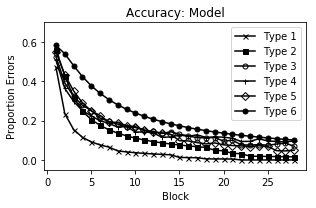

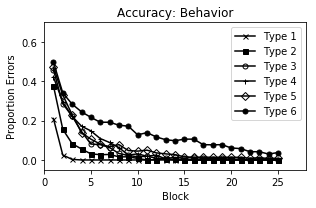

In [6]:
# %% Plotting overall correct
#         1      2    3    4    5     6
markers = ['x', 's', 'o', '+', 'D', 'o']
mfcs = ['none', 'k', 'none', 'none', 'none', 'k']
plt.figure(figsize=(4.5, 3))

# MODEL - - - - - - - - - - - - - - - -
dims = [1, 2, 3, 4, 5, 6]
for i, dim in enumerate(dims):
    plt.plot(np.arange(1, 29), df.loc[dim, :], label='Type %d' % dim,
             color='k', marker=markers[i], markersize=5, mfc=mfcs[i])

plt.title('Accuracy: Model')
plt.xlabel('Block')
plt.ylabel('Proportion Errors')
plt.ylim(-.05, .7)
plt.legend(bbox_to_anchor=(1, 1))
plt.yticks(np.arange(0., .7, .2))
plt.tight_layout()
plt.show()

# %% Nosofksy1994 Human data plt.figure(figsize=(4.2, 3))
plt.figure(figsize=(4.5, 3))

for i, dim in enumerate(range(1, 7)):
    plt.plot(
        np.arange(
            1,
            26),
        np.transpose(SHEP_HUMAN)[
            :,
            dim -
            1],
        label='Type %d' %
        dim,
        color='k',
        marker=markers[i],
        markersize=5,
        mfc=mfcs[i])
plt.title('Accuracy: Behavior')
plt.xlabel('Block')
plt.ylabel('Proportion Errors')
plt.ylim(-.05, .7)
plt.xlim(0, 28)
plt.xticks(np.arange(0, 29, 5))
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()

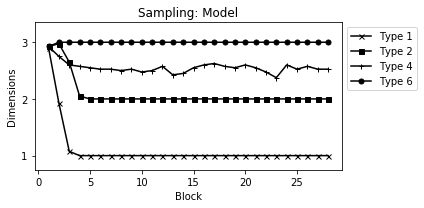

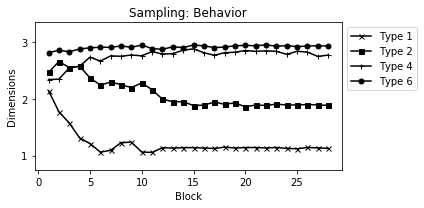

In [7]:
# %% Plot Model Sampling 

plt.figure(figsize=(5, 3))
df = pd.DataFrame(overall_sampled2, index=range(1, 7), columns=range(1, 29))
dims = [1, 2, 4, 6]

markers = ['x', 's', '+', 'o']
mfcs = ['none', 'k', 'none', 'k']
for i, dim in enumerate(dims):
    plt.plot(np.arange(1, 29), df.loc[dim, :], label='Type %d' % dim,
             color='k', marker=markers[i], markersize=5, mfc=mfcs[i])

plt.xlabel('Block')
plt.ylabel('Dimensions')
plt.title('Sampling: Model')
plt.ylim([.75, 3.35])
plt.yticks([1, 2, 3])
plt.tight_layout()
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

# plot Rehder Fixation Data
plt.figure(figsize=(5, 3))
df = pd.read_csv('behavioral_results/rehder_shjFixations.csv',header=None)
cType = np.array([1]*28 + [2]*28 + [4]*28 +[6]*28)
df.columns = ['x','y']
df['x'] = list(range(1,29))+list(range(1,29)) +list(range(1,29)) +list(range(1,29))

df['type'] = cType
m = np.hstack([df.loc[cType==i,['x','y']].values for i in [1,2,4,6]])
cols = ['Type_%d_%s'%(t,l) for t, l in it.product([1,2,4,6],['x','y'])]
df2 = pd.DataFrame(m,columns=cols)

#%% 
plt.close('all')
markers = ['x','s','+','o']
mfcs 	= ['none','k','none','k']
plt.figure(figsize=(5,3))
ax = plt.subplot(111)
for i,t in enumerate([1,2,4,6]):
    x,y = 'Type_%d_x'%t,'Type_%d_y'%t,
    plt.plot(df2.loc[:,x],df2.loc[:,y],label='Type %d'%t,color='k',
             marker=markers[i], markersize=5,mfc=mfcs[i])
plt.yticks([1,2,3])
plt.ylim([.75,3.35])
plt.title('Sampling: Behavior')
plt.ylabel('Dimensions')
plt.xlabel('Block')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1,1))
plt.show()